# Phase 4 - Improve Performance
In the previous phase of this project, I created three machine learning models to predict retention for Coursera. Initially, the models' performance was modest, i.e. near 70% recall which was our evaluation metric. By manipulating the threshold of the classification models, I could improve the recall to 95% which is good, but this came at the expense of reducing precision and accuracy to near 50%. The goodness of this results can be measured in a broader context. If we can evaluate the costs and benefits of TT, TF, FN, and FT, then we can say for sure whether this performance is satisfactory or not.<br>
For example, if Coursera admits that there is more cost in loosing a subscription than promoting to a learner who is not going to churn, then this model will be totally good.<br>
On the other hand, if Coursera in interested in a model with the highest accuracy and recall, this performance may not be up to par.<br>
In this notebook, I will try to improve the models mainly by means of feature engineering. I will drop some features, and transform some others. I will also return back to the exploratory data analysis to look for some clues to engineering some new features.

## Import Required Packages

In [1]:
# Standard Python packages
from math import sqrt
import pickle

# Data packages
import pandas as pd
import numpy as np

# Visualization Packages
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning / Classification packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,\
roc_auc_score, roc_curve, auc,\
confusion_matrix, classification_report,\
ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from xgboost import XGBClassifier
from xgboost import plot_importance


In [2]:
# Open pickled data
with open('Data//coursera data.pickle', 'rb') as file:
    df = pickle.load(file)

df.shape

(413953, 38)

In [3]:
df['is_churned'] = 1 - df['is_retained']
df.head()

,subscription_id,observation_dt,is_retained,specialization_id,cnt_courses_in_specialization,specialization_domain,is_professional_certificate,is_gateway_certificate,learner_days_since_registration,learner_country_group,...,cnt_items_completed_during_payment_period,cnt_graded_items_completed_during_payment_period,is_active_capstone_during_pay_period,sum_hours_learning_before_payment_period,sum_hours_learning_during_payment_period,cnt_days_active_before_payment_period,cnt_days_active_during_payment_period,cnt_days_since_last_activity,Popularity,is_churned
0,--rKikbGEeyQHQqIvaM5IQ,2022-05-04,1.0,kr43OcbTEeqeNBKhfgCLyw,8.0,Data Science,True,True,2321.0,Northern Europe,...,0.0,0.0,False,73.783333,0.000000,68.0,0.0,20.0,1.995327,0.0
1,-0XGzEq2EeyimBISGRuNeQ,2021-11-30,0.0,Q0Fc_Yl0EeqdTApgQ4tM7Q,6.0,Data Science,True,False,612.0,Northern Europe,...,0.0,0.0,False,0.850000,0.000000,7.0,2.0,0.0,1.995327,1.0
2,-1P9kOb6EeuRugq1Liq62w,2021-08-13,0.0,9kmimrDIEeqxzQqieMm42w,6.0,Business,True,True,27.0,Australia and New Zealand,...,12.0,2.0,False,1.833333,2.983333,2.0,1.0,18.0,0.850538,1.0
3,-2ifTJZbEeuIuRKpAhovaw,2021-08-03,1.0,7lHCSlFIEeeffRIHljDI_g,5.0,Information Technology,True,True,120.0,United States,...,83.0,9.0,False,18.450000,7.100000,18.0,4.0,3.0,1.438645,0.0
4,-5YKZbchEeufeAq6C_fAOw,2021-06-04,0.0,kr43OcbTEeqeNBKhfgCLyw,8.0,Data Science,True,True,1228.0,India,...,61.0,4.0,False,29.566667,15.250000,18.0,8.0,1.0,1.995327,1.0


## Remove Irrelevant Columns

In [4]:
to_be_removed = ['subscription_id', 'observation_dt', 'specialization_id', 'learner_gender']
# ['learner_days_since_registration', 'specialization_domain', 'learner_country_group']
df1 = df.drop(to_be_removed, axis=1)
df1.shape

(413953, 35)

## Handle Outliers

In [5]:
# Utility function to find and cap the outliers

def cap_outlier(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    IQR = q3 - q1
    lower_limit = q1 - 1.5 * IQR
    upper_limit = q3 + 1.5 * IQR

    column = np.where(df[col] > upper_limit, upper_limit, 
                       np.where(df[col] < lower_limit, lower_limit, df[col]))
    return column


In [6]:
for col in df1.columns:
    if df1[col].dtype in ["int64","float64"]:
        df1[col] = cap_outlier(df1, col)

df1.describe()

,is_retained,cnt_courses_in_specialization,learner_days_since_registration,learner_cnt_other_courses_active,learner_cnt_other_courses_paid_active,learner_cnt_other_courses_items_completed,learner_cnt_other_courses_paid_items_completed,learner_cnt_other_transactions_past,learner_other_revenue,subscription_period_order,...,cnt_enrollments_active_during_payment_period,cnt_items_completed_during_payment_period,cnt_graded_items_completed_during_payment_period,sum_hours_learning_before_payment_period,sum_hours_learning_during_payment_period,cnt_days_active_before_payment_period,cnt_days_active_during_payment_period,cnt_days_since_last_activity,Popularity,is_churned
count,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,...,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000
mean,0.543663,5.919438,713.807029,2.718632,0.555917,56.487657,8.042605,0.637449,30.626475,2.248905,...,0.627710,12.179784,1.053938,12.415559,2.159619,10.200452,2.298471,21.194913,1.317979,0.456337
std,0.498090,1.736631,874.870052,3.630505,0.932907,83.313962,13.583526,0.995666,48.620278,1.657074,...,0.769763,18.159668,1.737287,14.487067,3.173857,10.979661,3.169519,26.136959,0.551951,0.498090
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.162325,0.000000
25%,0.000000,5.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.150000,0.000000,2.000000,0.000000,1.000000,0.850538,0.000000
50%,1.000000,6.000000,279.000000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,6.183333,0.000000,6.000000,1.000000,9.000000,0.957605,0.000000
75%,1.000000,7.000000,1109.000000,4.000000,1.000000,90.000000,13.000000,1.000000,49.000000,3.000000,...,1.000000,20.000000,2.000000,18.633333,3.533333,15.000000,4.000000,32.000000,1.995327,1.000000
max,1.000000,10.000000,2666.000000,10.000000,2.500000,225.000000,32.500000,2.500000,122.500000,6.000000,...,2.500000,50.000000,5.000000,44.858333,8.833333,34.500000,10.000000,78.500000,1.995327,1.000000


## Feature Engineering
The feature importance chart in phase 4, as well as the exploratory data analysis in phase 1 revealed that the more engaged are learners with their current and previos courses, the more likely they keep up learning and retain. So, in this section I am going to create a feature that represents engagement and another feature that indicates if they are near the end of the current specialization.<br>
First, I have to standardize the data.

In [7]:
popular_domains = ['Data Science', 'Business', 'Computer Science', 'Information Technology']
df1['is_popular_domain'] = df['specialization_domain'].isin(popular_domains)

df1[['is_popular_domain', 'specialization_domain']].head()

,is_popular_domain,specialization_domain
0,True,Data Science
1,True,Data Science
2,True,Business
3,True,Information Technology
4,True,Data Science


In [8]:
columns = ['learner_country_group', 'is_retained']
g = df1.groupby(columns, observed=True).size().unstack()
g = g.fillna(0)
g.columns = ['Churned', 'Retained']
g['Total'] = g.sum(axis=1)
g['Region Retention%'] = ((g['Retained'] / g['Total']) * 100).round(2)

right = g.reset_index()[['learner_country_group', 'Region Retention%']]

df1 = pd.merge(df1, right, on='learner_country_group')
df1[['learner_country_group', 'Region Retention%']].head()

,learner_country_group,Region Retention%
0,Northern Europe,53.54
1,Northern Europe,53.54
2,Australia and New Zealand,53.40
3,United States,60.53
4,India,37.83


In [9]:
to_drop = ['learner_country_group', 'specialization_domain']
df1.drop(to_drop, inplace=True, axis=1)
df1.shape

(413953, 35)

In [10]:
# create 'percent_done' feature
df1['percent_done'] = (100 * df1['cnt_enrollments_completed_before_payment_period'
                       ] / df1['cnt_courses_in_specialization']).round(2)


## Normalize Numeric Columns

In [12]:
nums = df1.select_dtypes(include=['int64','float64'])
bools = df1.select_dtypes(include=['bool','category'])

print("Numeric columns:", len(nums.columns.values))
print("Bool and category columns:", len(bools.columns.values))
print("All columns:", len(df1.columns.values))



Numeric columns: 31
Bool and category columns: 5
All columns: 36


In [13]:
min_max_scaler = MinMaxScaler() 
scaled = min_max_scaler.fit_transform(nums)

scaled = pd.DataFrame(scaled, columns=nums.columns)
df2 = pd.concat([scaled, bools], axis=1)

df2.head()

,is_retained,cnt_courses_in_specialization,learner_days_since_registration,learner_cnt_other_courses_active,learner_cnt_other_courses_paid_active,learner_cnt_other_courses_items_completed,learner_cnt_other_courses_paid_items_completed,learner_cnt_other_transactions_past,learner_other_revenue,subscription_period_order,...,cnt_days_since_last_activity,Popularity,is_churned,Region Retention%,percent_done,is_professional_certificate,is_gateway_certificate,is_subscription_started_with_free_trial,is_active_capstone_during_pay_period,is_popular_domain
0,1.0,0.714286,0.870593,0.8,0.0,0.391111,0.0,0.0,0.000000,1.0,...,0.254777,1.000000,0.0,0.692070,0.375015,True,True,False,False,True
1,0.0,0.428571,0.229557,1.0,0.8,0.928889,1.0,0.4,0.403347,0.0,...,0.000000,1.000000,1.0,0.692070,0.000000,True,False,True,False,True
2,0.0,0.428571,0.010128,0.5,0.0,0.022222,0.0,0.0,0.000000,0.0,...,0.229299,0.375457,1.0,0.685903,0.000000,True,True,True,False,True
3,1.0,0.285714,0.045011,0.0,0.0,0.000000,0.0,0.0,0.000000,0.6,...,0.038217,0.696300,0.0,1.000000,0.240010,True,True,True,False,True
4,0.0,0.714286,0.460615,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.012739,1.000000,1.0,0.000000,0.150006,True,True,True,False,True


## Feature Creation

In [15]:

df2['without_pos'] = df2[without_p].sum(axis=1).astype('float32')
df2['without_neg'] = df2[without_n].sum(axis=1).astype('float32')
df2['within_pos'] = df2[within_p].sum(axis=1).astype('float32')
df2['within_neg'] = df2[within_n].sum(axis=1).astype('float32')

df2.head()

,is_retained,cnt_courses_in_specialization,learner_days_since_registration,learner_cnt_other_courses_active,learner_cnt_other_courses_paid_active,learner_cnt_other_courses_items_completed,learner_cnt_other_courses_paid_items_completed,learner_cnt_other_transactions_past,learner_other_revenue,subscription_period_order,...,percent_done,is_professional_certificate,is_gateway_certificate,is_subscription_started_with_free_trial,is_active_capstone_during_pay_period,is_popular_domain,without_pos,without_neg,within_pos,within_neg
0,1.0,0.714286,0.870593,0.8,0.0,0.391111,0.0,0.0,0.000000,1.0,...,0.375015,True,True,False,False,True,6.322581,3.549708,1.191111,0.000000
1,0.0,0.428571,0.229557,1.0,0.8,0.928889,1.0,0.4,0.403347,0.0,...,0.000000,True,False,True,False,True,1.678531,0.863728,3.728889,0.803347
2,0.0,0.428571,0.010128,0.5,0.0,0.022222,0.0,0.0,0.000000,0.0,...,0.000000,True,True,True,False,True,2.163985,1.396487,0.522222,0.000000
3,1.0,0.285714,0.045011,0.0,0.0,0.000000,0.0,0.0,0.000000,0.6,...,0.240010,True,True,True,False,True,6.441786,2.523089,0.000000,0.000000
4,0.0,0.714286,0.460615,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.150006,True,True,True,False,True,6.599865,2.371344,0.000000,0.000000


In [33]:
# df2.info()

In [17]:
X = df2.drop(['is_churned'], axis=1)
y = df2['is_churned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [18]:

min_max_scaler = MinMaxScaler() 
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)


## Utility Functions for Creating Reports

In [19]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [20]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

## Build Logistic Regression Model

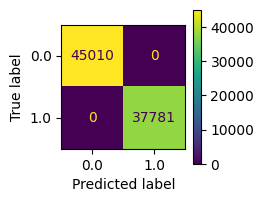

In [21]:
clf = LogisticRegression().fit(X_train,y_train)
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)

fig, ax = plt.subplots(figsize=(2,2))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)
disp.plot(ax=ax)


In [22]:
recall_score(y_test,y_pred)


np.float64(1.0)

In [23]:
results = pd.DataFrame()
lr_results = get_test_scores('lr', y_pred, y_test)
results = pd.concat([results, lr_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,lr,1.0,1.0,1.0,1.0


## Build XGBoost Model

In [24]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

param_grid = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

scoring = ['accuracy', 'precision', 'recall', 'f1']

xgb_cv = GridSearchCV(xgb, param_grid, scoring=scoring, cv=4, refit='recall')

In [25]:
%%time
xgb_cv.fit(X_train, y_train)


CPU times: total: 10min 7s
Wall time: 3min 3s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [26]:
# Examine best score
xgb_cv.best_score_

np.float64(1.0)

In [27]:
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,lr,1.0,1.0,1.0,1.0
0,XGB cv,1.0,1.0,1.0,1.0


## Build Random Forest Model

In [28]:
rf = RandomForestClassifier(random_state=42)

param_grid = {'max_depth': [4, 6, 8],
             'max_features': [None],
             'max_samples': [None],
             'min_samples_leaf': [3, 5],
             'min_samples_split': [2, 4],
             'n_estimators': [100],
             }

scoring = ['accuracy', 'precision', 'recall', 'f1']

rf_cv = GridSearchCV(rf, param_grid, scoring=scoring, cv=4, refit='recall')


In [29]:
%%time
rf_cv.fit(X_train, y_train)


CPU times: total: 29min 20s
Wall time: 29min 27s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [4, 6, 8], 'max_features': [None],
                         'max_samples': [None], 'min_samples_leaf': [3, 5],
                         'min_samples_split': [2, 4], 'n_estimators': [100]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [30]:
rf_cv.best_score_

np.float64(1.0)

In [31]:
# results = pd.DataFrame()
rf_results = make_results('RF cv', rf_cv, 'recall')
results = pd.concat([results, rf_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,lr,1.0,1.0,1.0,1.0
0,XGB cv,1.0,1.0,1.0,1.0
0,RF cv,1.0,1.0,1.0,1.0


## Pickle Models

In [32]:
import pickle
with open('Pickled Models//RandomForest100.pickle', 'wb') as file:
    pickle.dump(rf_cv, file) 

with open('Pickled Models//XGBoost100.pickle', 'wb') as file:
    pickle.dump(xgb_cv, file) 

print('Done!')

Done!


## Conclusion
In this notebook, I did my bests at feature engineering and the outcome was beyond my expectations. I returned back to phase 1 of this project and identified columns with positive and negative correlation with the target column. Then, I combined columns in each group to engineer new features. New features joined the original features of the data to make three perfect models.<br>
I'm really happy :-)